<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

#### Note
the default version of altair in colab doesn't work with xplainable, so run this script to upgrade it

```sh
pip install --upgrade xplainable altair
pip install statsmodels
```

### Load Libraries

In [ ]:
#|eval: false
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xplainable.core.models import XRegressor
from xplainable.core.optimisation.genetic import XEvolutionaryNetwork
from xplainable.core.optimisation.layers import Tighten, Evolve
from statsmodels.tsa.seasonal import seasonal_decompose

## Define the Forecasting Class
We will add an enhanced version of this to the xplainable package in the future. This is a fast and dirty approach.

In [ ]:
#|eval: false
class XForecast:
    """ML Forecasting with xplainable.

      This is whipped together for testing – feel free to update and adjust.

    """
    def __init__(self, model, pipeline, trend_decompose=True):
        self.model = model
        self.pipeline = pipeline
        self.trend_decompose = trend_decompose
        self.target_column = None
        self.slope = None
        self.intercept = None
        self.observations = None

    def _apply_transformations(self, data, is_train=True):
        """Fast and dirty feature preprocessor"""
        transformed_data = data.copy()

        transformed_data['month'] = transformed_data.index.month

        for column, operations in self.pipeline.items():
            if column not in transformed_data.columns:
                continue

            if "lag" in operations:
                for lag in operations["lag"]:
                    transformed_data[f"{column}_lag{lag}"] = \
                    transformed_data[column].shift(lag)

            if "rolling" in operations:
                for window in operations["rolling"]:
                    transformed_data[f"{column}_rolling{window}"] = \
                    transformed_data[column].rolling(window).mean()

            if "gradient" in operations:
                for gradient in operations["gradient"]:
                    transformed_data[f"{column}_gradient{gradient}"] = (
                        transformed_data[column].shift(1) - \
                        transformed_data[column].shift(1+gradient)) / \
                        transformed_data[column].shift(1+gradient)

            if "change" in operations:
                for n_steps in operations["change"]:
                    transformed_data[f"{column}_change{n_steps}"] = \
                    transformed_data[column] - transformed_data[column].shift(
                        n_steps)

            if "impute" in operations:
                method = operations["impute"]
                transformed_data[column].fillna(method=method, inplace=True)

        if is_train:
            transformed_data.dropna(inplace=True)

        return transformed_data

    def _get_trend_coefficients(self, trend_data):
        """Essentially a linear regression on the trend values"""

        # Calculate linear model on trend
        y_values = trend_data.values[~np.isnan(trend_data.values)]
        self.observations = len(y_values)
        x_values = np.arange(len(y_values))

        sum_x = sum(x_values)
        sum_y = sum(y_values)
        sum_x_squared = sum(x**2 for x in x_values)
        sum_xy = sum(x*y for x, y in zip(x_values, y_values))
        n = len(x_values)

        # Calculate slope m and y-intercept c
        slope = (n * sum_xy - sum_x * sum_y) / (n * sum_x_squared - sum_x**2)
        intercept = (sum_y - slope * sum_x) / n

        return slope, intercept

    def fit(self, data, target_column, opt=False):
        """Fits the data to the model. `opt` will optimise the xplainable model
        """

        data = data.copy()
        self.target_column = target_column

        if self.trend_decompose:
            # Perform STL decomposition
            result = seasonal_decompose(data[target_column], model='additive')

            # Remove the trend
            detrended = data[target_column] - result.trend

            # Calculate the LR coefficient and intercept
            self.slope, self.intercept = self._get_trend_coefficients(
                result.trend)

            data[target_column] = detrended.values
            # Will remove the first and last 3 rows because of rolling window
            data = data.dropna()

        # Run pipeline
        train_data = self._apply_transformations(data)

        X_train = train_data.drop(target_column, axis=1)
        y_train = train_data[target_column]

        # Fit the model
        self.model.fit(X_train, y_train)

        # Only run this line if using xplainable
        if self.model.__class__.__name__ == 'XRegressor':
            self.model.optimise_tail_sensitivity(X_train, y_train)

        # This can only be done on xplainable models
        if opt:
            # Create the network
            network = XEvolutionaryNetwork(self.model)

            # Add the layers
            # Add an Evolve layer with a high severity
            network.add_layer(
                Evolve(
                    mutations=100,
                    generations=50,
                    max_severity=0.5,
                    max_leaves=20,
                    early_stopping=20
                    )
                )

            # Add another Evolve layer with a lower severity and reach
            network.add_layer(
                Evolve(
                    mutations=100,
                    generations=50,
                    max_severity=0.3,
                    max_leaves=15,
                    early_stopping=20
                    )
                )

            # Fit the network (before or after adding layers)
            network.fit(X_train, y_train)

            # Run the network
            network.optimise()

    def predict(self, data, nsteps=1):
        data = data.copy()

        offset = 0
        if self.trend_decompose:
            # Offset is due to the dropped nan values when decomposing in fit()
            offset = -6

        forecast_dates = pd.date_range(
            start=data.index[-1] + pd.DateOffset(months=offset),
            periods=nsteps, freq='MS')

        if self.trend_decompose:
            result = seasonal_decompose(
                data[self.target_column], model='additive')

            # Removing the seasonality
            detrended = data[self.target_column] - result.trend
            data[self.target_column] = detrended.values
            data = data.dropna()
            trend_idxs = np.arange(len(data), len(data) + nsteps)
            predicted_trend = (trend_idxs * self.slope) + self.intercept

        predictions = []
        for _ in range(nsteps):
            transformed_data = self._apply_transformations(data, is_train=False)

            X_pred = transformed_data.iloc[-1].drop(
                labels=[self.target_column], errors='ignore')

            X_pred = pd.DataFrame(X_pred).T
            y_pred = self.model.predict(X_pred)[0]
            predictions.append(y_pred)

            new_index = data.index[-1] + pd.DateOffset(months=1)
            new_data_row = pd.DataFrame(
                {self.target_column: [y_pred]}, index=[new_index])

            data = pd.concat([data, new_data_row])

        if self.trend_decompose:
          predictions = predictions + predicted_trend

        output = pd.DataFrame({
            'date': forecast_dates,
            'forecast': predictions
        })

        return output

    def plot_predictions(self, X, prediction_df):

        # Plot actual data
        plt.figure(figsize=(14, 7))
        plt.plot(X.index, train["Passengers"], label="Actual", color="blue")

        # Plot Prediction
        plt.plot(
            prediction_df.date,
            prediction_df.forecast,
            label="Forecast",
            linestyle="--",
            color="red"
            )

        plt.title("Monthly Air Passengers: Actual vs Forecast")
        plt.xlabel("Date")
        plt.ylabel("Number of Passengers")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Load Example Data

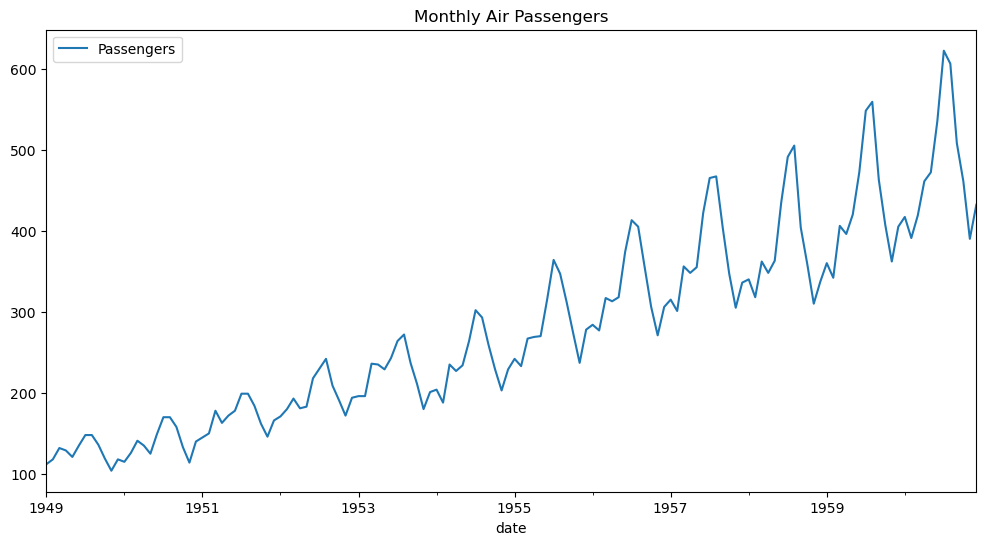

In [ ]:
#|eval: false
# Load the dataset
flights = sns.load_dataset("flights")

# Convert month names to datetime format with the given year
flights['date'] = flights.apply(lambda row: pd.to_datetime(f"{row['year']}-{row['month']}-01"), axis=1)
flights.set_index('date', inplace=True)

# Drop redundant columns and rename the passengers column for clarity
flights.drop(['year', 'month'], axis=1, inplace=True)
flights.rename(columns={'passengers': 'Passengers'}, inplace=True)

# Plot the data
flights.plot(title="Monthly Air Passengers", figsize=(12,6))
plt.show()

In [ ]:
#|eval: false
train = flights.copy()

# Filter on later dates gives better results in this example
train = train[train.index >= '1956-07-01']

In [ ]:
#|eval: false
pipeline = {
    "Passengers": {
        "lag": [12], # Select
        "impute": "ffill"
    }
}

model = XForecast(XRegressor(max_depth=7), pipeline, trend_decompose=True)
model.fit(train, "Passengers", opt=False) # Setting opt=True can be a little slow. Set to False for quick testing

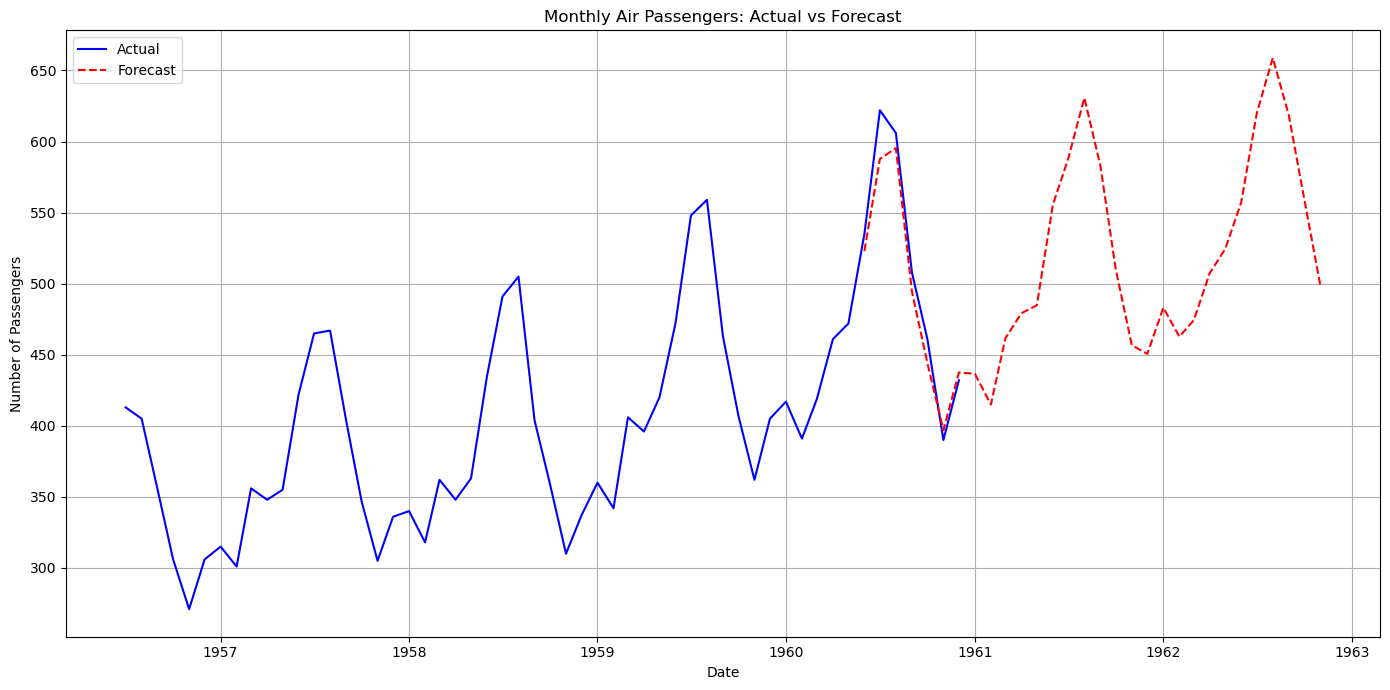

In [ ]:
#|eval: false
nsteps = 30  # You can change this to the desired forecast length

predictions = model.predict(train, nsteps=nsteps)
model.plot_predictions(train, predictions)

## Explainers

### xplainable model
Note that this explainer ignores trend when decomposition is applied. See below to understand how the trend line comes into play.

In [ ]:
#|eval: false
model.model.explain()

alt.HConcatChart(...)

### Trend

The trend starts with an intercept of 342.33 and a slope coefficient of 2.95



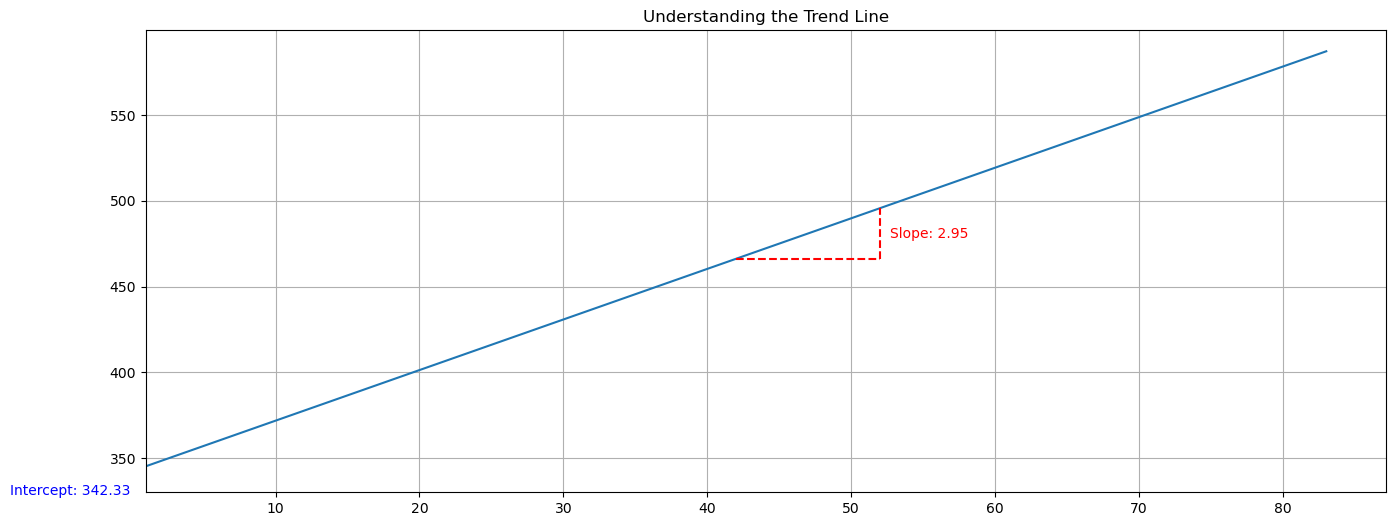

In [ ]:
#|eval: false
print(f'The trend starts with an intercept of {round(model.intercept, 2)} and a slope coefficient of {round(model.slope, 2)}\n')

ax, fig = plt.subplots(figsize=(16, 6))
_len = len(train)+nsteps
plt.plot(np.arange(0, _len) * model.slope + model.intercept)

# Calculate y0 and y1
y0 = model.intercept
y1 = 10 * model.slope + model.intercept

# Assume we want to illustrate the slope from the midpoint
midpoint = _len // 2
y_at_midpoint = midpoint * model.slope + model.intercept

# Add a horizontal line from the middle of the line going across ten units
plt.plot([midpoint, midpoint+10], [y_at_midpoint, y_at_midpoint], 'r--')

# Add a vertical line going from the end of the horizontal line back to the slope
plt.plot([midpoint+10, midpoint+10], [y_at_midpoint, y_at_midpoint + 10 * model.slope], 'r--')

# # Label for intercept and slope
ax.text(0.04, 0.1, f'Intercept: {round(y0, 2)}', verticalalignment='bottom', color='blue')
ax.text(0.59, 0.54, f'Slope: {round(model.slope, 2)}', verticalalignment='center', color='red')
fig.set_xlim(1, None)

plt.title("Understanding the Trend Line")
plt.grid(True)
plt.show()